In [2]:
# 1. Setup and Load Data

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set Display Options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Paths
cwd = Path.cwd()
BASE_DIR = cwd.parent

DATA_PROCESSED_DIR = BASE_DIR / "data" / "processed"
REPORTS_DIR = BASE_DIR / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"

DATA_PROCESSED_DIR, REPORTS_DIR, FIGURES_DIR


(WindowsPath('c:/Users/Lenovo/Documents/GitHub/Demographic-Change_Understanding-Fertility-Through-Data/data/processed'),
 WindowsPath('c:/Users/Lenovo/Documents/GitHub/Demographic-Change_Understanding-Fertility-Through-Data/reports'),
 WindowsPath('c:/Users/Lenovo/Documents/GitHub/Demographic-Change_Understanding-Fertility-Through-Data/reports/figures'))

In [4]:
# Import Final Dataset
panel_path = DATA_PROCESSED_DIR / "analysis_base_with_full_interpolation.csv"

# Check
assert panel_path.exists(), f"File Not Found: {panel_path}"

df = pd.read_csv(panel_path)

print("Shape:", df.shape)
print(df.head())

print("\nNaN Rates:")
print(df.isna().mean())


Shape: (12449, 6)
       Country  Year  fertility  migration  urban_pop  flfp
0  Afghanistan  1960      7.282     2606.0      8.401  6.83
1  Afghanistan  1961      7.284     6109.0      8.684  6.83
2  Afghanistan  1962      7.292     7016.0      8.976  6.83
3  Afghanistan  1963      7.302     6681.0      9.276  6.83
4  Afghanistan  1964      7.304     7079.0      9.586  6.83

NaN Rates:
Country      0.0
Year         0.0
fertility    0.0
migration    0.0
urban_pop    0.0
flfp         0.0
dtype: float64


In [5]:
# Basic Checks on the Panel Structure
years = df["Year"].unique()
countries = df["Country"].unique()

print(f"Years Range: {years.min()} - {years.max()}")
print(f"Number of Countries: {len(countries)}")
print(f"Total Rows: {len(df)}")

print("\nColumns:", df.columns.tolist())


Years Range: 1960 - 2018
Number of Countries: 211
Total Rows: 12449

Columns: ['Country', 'Year', 'fertility', 'migration', 'urban_pop', 'flfp']


In [6]:
# Country-Wise Train-Test Split

from typing import Tuple

def country_based_train_test_split(
    data: pd.DataFrame,
    country_col: str = "Country",
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    
    
    For each country:
      - Shuffle its rows
      - Assign the first (1 - test_size) fraction to train
      - Assign the remaining fraction to test
    
    Parameters
    ----------
    data : pd.DataFrame
        Panel data with at least [country_col, Year, features, target].
    country_col : str
        Name of the country identifier column.
    test_size : float
        Fraction of rows for each country that will go into the test set (0 < test_size < 1).
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    train_df : pd.DataFrame
        Training subset of the panel.
    test_df : pd.DataFrame
        Test subset of the panel.
    """
    
    rng = np.random.RandomState(random_state)
    
    train_parts = []
    test_parts = []
    
    countries = data[country_col].unique()
    print(f"Splitting data for {len(countries)} countries...")
    
    for c in countries:
        country_df = data[data[country_col] == c].copy()
        
        # Shuffle Within Country
        country_df = country_df.sample(frac=1.0, random_state=rng.randint(0, 10**6))
        
        # Compute Split Index
        n = len(country_df)
        split_idx = int(n * (1.0 - test_size))
        if split_idx == 0 or split_idx == n:
            # Edge Case (Very Small Country Series)
            # Put At Least One Row In Both Sets If Possible
            split_idx = max(1, min(n - 1, split_idx))
        
        train_parts.append(country_df.iloc[:split_idx])
        test_parts.append(country_df.iloc[split_idx:])
    
    train_df = pd.concat(train_parts, axis=0).reset_index(drop=True)
    test_df = pd.concat(test_parts, axis=0).reset_index(drop=True)
    
    return train_df, test_df


In [7]:
# Country-Based Train–Test Split
TEST_SIZE = 0.2  # 20% test, 80% train

train_df, test_df = country_based_train_test_split(
    df,
    country_col="Country",
    test_size=TEST_SIZE,
    random_state=42
)

print("Train Shape:", train_df.shape)
print("Test Shape :", test_df.shape)

# Check that all countries appear in both splits
train_countries = set(train_df["Country"].unique())
test_countries = set(test_df["Country"].unique())

print("\nCountries Only In Train:", len(train_countries - test_countries))
print("Countries Only In Test :", len(test_countries - train_countries))
print("Countries In Both      :", len(train_countries & test_countries))

Splitting data for 211 countries...
Train Shape: (9917, 6)
Test Shape : (2532, 6)

Countries Only In Train: 0
Countries Only In Test : 0
Countries In Both      : 211


Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\fertility_train_vs_test_distribution.png


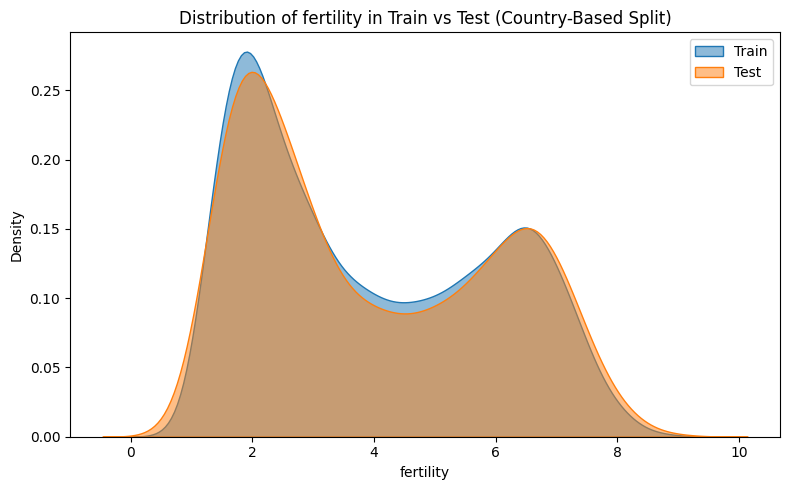

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\flfp_train_vs_test_distribution.png


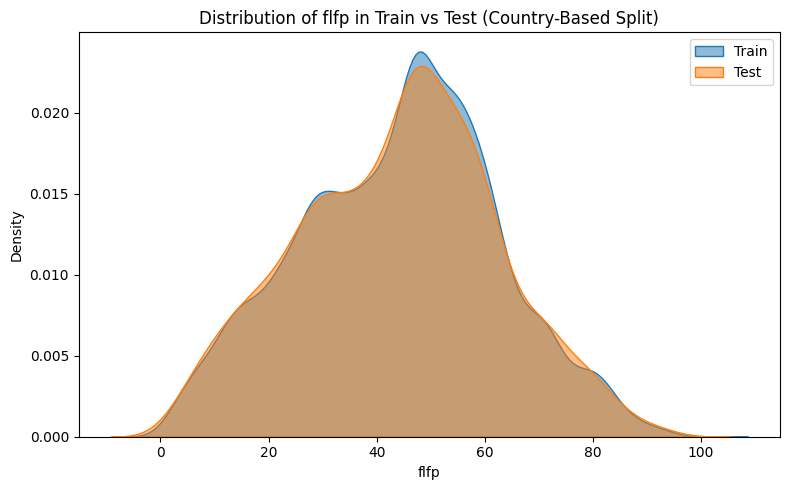

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\urban_pop_train_vs_test_distribution.png


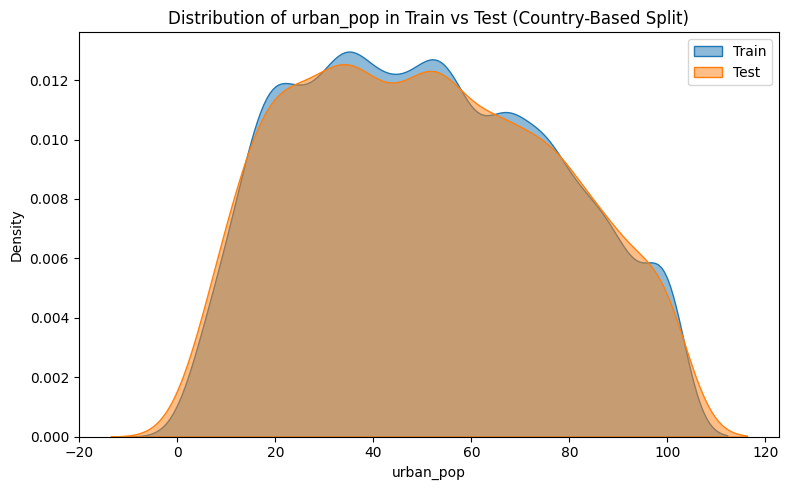

Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\migration_train_vs_test_distribution.png


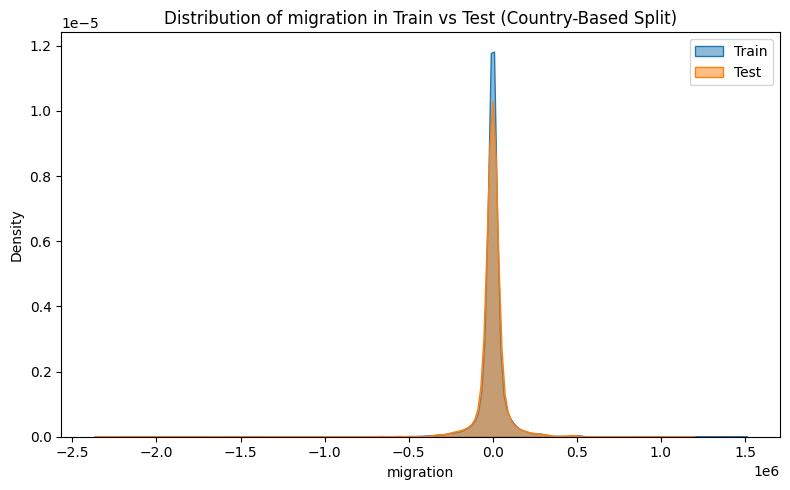

In [8]:
# Global Ratio Check
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

variables = ["fertility", "flfp", "urban_pop", "migration"]

for var in variables:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(train_df[var], label="Train", fill=True, alpha=0.5)
    sns.kdeplot(test_df[var], label="Test", fill=True, alpha=0.5)

    plt.xlabel(var)
    plt.ylabel("Density")
    plt.title(f"Distribution of {var} in Train vs Test (Country-Based Split)")
    plt.legend()
    plt.tight_layout()

    # Save Figure
    fig_path = FIGURES_DIR / f"{var}_train_vs_test_distribution.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    print(f"Saved: {fig_path}")

    plt.show()

In [9]:
# Save Train and Test Sets
train_path = DATA_PROCESSED_DIR / "panel_country_split_train.csv"
test_path = DATA_PROCESSED_DIR / "panel_country_split_test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved Train Set To:", train_path)
print("Saved Test Set To :", test_path)


Saved Train Set To: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\panel_country_split_train.csv
Saved Test Set To : c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\panel_country_split_test.csv


In [10]:
# Global Ratio Check
n_total = len(df)
n_train = len(train_df)
n_test = len(test_df)

train_ratio = n_train / n_total
test_ratio = n_test / n_total

print(f"Total Rows : {n_total}")
print(f"Train Rows : {n_train} ({train_ratio:.3%})")
print(f"Test Rows  : {n_test} ({test_ratio:.3%})")


Total Rows : 12449
Train Rows : 9917 (79.661%)
Test Rows  : 2532 (20.339%)


In [11]:
# Country-Level Row Counts in Train and Test
train_counts = train_df["Country"].value_counts().sort_index()
test_counts = test_df["Country"].value_counts().sort_index()

country_stats = pd.DataFrame({
    "train_rows": train_counts,
    "test_rows": test_counts
}).fillna(0).astype(int)

country_stats_path = REPORTS_DIR / "country_split_row_counts.csv"
country_stats.to_csv(country_stats_path)

print(f"Saved Country Split Stats To: {country_stats_path}")
country_stats.head()

Saved Country Split Stats To: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\country_split_row_counts.csv


,train_rows,test_rows
Country,,
Afghanistan,47,12
Albania,47,12
Algeria,47,12
Andorra,47,12
Angola,47,12


In [12]:
# Country-Based Train/Test Split Report
import json

train_countries = set(train_df["Country"].unique())
test_countries = set(test_df["Country"].unique())

only_train = sorted(train_countries - test_countries)
only_test = sorted(test_countries - train_countries)
in_both = sorted(train_countries & test_countries)

split_report = {
    "n_countries_total": len(train_countries | test_countries),
    "n_countries_only_in_train": len(only_train),
    "n_countries_only_in_test": len(only_test),
    "n_countries_in_both": len(in_both),
    "countries_only_in_train": only_train,
    "countries_only_in_test": only_test
}

split_report_path = REPORTS_DIR / "country_split_report.json"
with open(split_report_path, "w", encoding="utf-8") as f:
    json.dump(split_report, f, indent=4, ensure_ascii=False)

print(f"Saved Split Report To: {split_report_path}")
split_report

Saved Split Report To: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\country_split_report.json


{'n_countries_total': 211,
 'n_countries_only_in_train': 0,
 'n_countries_only_in_test': 0,
 'n_countries_in_both': 211,
 'countries_only_in_train': [],
 'countries_only_in_test': []}